In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
from gdml_jax.util.datasets import load_md17, get_symmetries
from gdml_jax.kernels import sGDMLKernel, rbf
from gdml_jax.models import GDMLPredict, GDMLPredictEnergy
from gdml_jax.solve import solve_closed
from gdml_jax import losses
from matern import matern52

# enable double precision
config.update("jax_enable_x64", True)

# args
DATA_DIR = "/tmp/md17"
MOLECULE = "ethanol"
N_TRAIN = 100
N_TEST = 200
LENGTHSCALE = jnp.float64(10.)
REG = jnp.float64(1e-10)

# data loading
trainset, testset, meta = load_md17(MOLECULE, N_TRAIN, N_TEST, DATA_DIR)
train_x, train_e, train_f = trainset
shape = meta["shape"]

# define basekernel and model
perms = get_symmetries(MOLECULE)
basekernel = sGDMLKernel(shape, perms=perms, kappa=rbf)
kernel_kwargs = {"lengthscale": LENGTHSCALE}

# solve in closed form
params = solve_closed(basekernel, train_x, train_f, reg=REG, kernel_kwargs=kernel_kwargs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
jax.tree_map(jnp.shape, params)

{'alpha': (100, 9, 3), 'kernel_kwargs': {'lengthscale': ()}}

In [3]:
test_x, test_e, test_f = testset
force_fn = GDMLPredict(basekernel, train_x)
preds_f = force_fn(params, test_x)
print("forces:")
print(f"test MSE: {losses.mse(test_f, preds_f)}")
print(f"test MAE: {losses.mae(test_f, preds_f)}")

energy_fn = GDMLPredictEnergy(basekernel, train_x, train_e, params)
preds_e = energy_fn(test_x)
print("energies:")
print(f"test MSE: {losses.mse(test_e, preds_e)}")
print(f"test MAE: {losses.mae(test_e, preds_e)}")

forces:
test MSE: 4.146085838737379
test MAE: 1.4508398670445657
energies:
test MSE: 0.34129418094926595
test MAE: 0.4635435465536284


## Evaluating the scalar basekernel

In [4]:
basekernel(train_x[0], train_x[1], **kernel_kwargs)

Array(0.9994023, dtype=float64)

In [5]:
jax.grad(basekernel)(train_x[0], train_x[0], **kernel_kwargs)

Array([[ 4.18021557e-06, -4.00392066e-06,  2.71672859e-06],
       [ 1.65503509e-04,  4.63437773e-04, -6.77787033e-04],
       [-1.82819573e-06, -4.81822197e-05, -3.35350870e-05],
       [ 6.65906797e-05,  6.95985057e-05, -5.19324470e-05],
       [-8.29166152e-05, -5.92104139e-05, -4.56246253e-05],
       [-2.73364042e-04, -4.32283907e-04,  2.47936142e-04],
       [-2.33762466e-04,  6.12563761e-05,  1.06583528e-04],
       [ 3.10325363e-04, -9.71276608e-06,  4.40247099e-04],
       [ 4.52715524e-05, -4.08994273e-05,  1.13956947e-05]],      dtype=float64)

In [6]:
jax.jacfwd(jax.grad(basekernel), argnums=1)(train_x[0], train_x[0], **kernel_kwargs)

Array([[[[ 4.82881933e-03,  1.91833182e-03,  4.72131021e-06],
         [-9.17649358e-05,  2.90795912e-04,  2.54596242e-04],
         [-2.44144777e-03, -3.73462913e-04,  5.03194199e-04],
         [-5.03085855e-04, -2.26025005e-03,  8.73714370e-04],
         [-1.40981596e-03,  3.29400436e-04, -2.02304648e-03],
         [-4.36826014e-06,  6.32887641e-05,  1.09445653e-05],
         [-4.05716921e-05,  3.05259081e-05,  4.40728256e-05],
         [ 1.42490548e-05,  4.20389616e-05,  5.09425415e-05],
         [-3.52013914e-04, -4.06688390e-05,  2.80860429e-04]],

        [[ 1.91833182e-03,  3.53430142e-03,  2.32661387e-03],
         [ 2.90792950e-04, -9.21487703e-04, -8.06793166e-04],
         [-3.73462486e-04, -5.71275141e-05,  7.69725791e-05],
         [-5.07859377e-04, -2.28169387e-03,  8.82003740e-04],
         [-1.42298998e-03,  3.32479711e-04, -2.04195240e-03],
         [ 1.93447385e-05, -2.80372513e-04, -4.84806714e-05],
         [ 1.79633636e-04, -1.35157028e-04, -1.95132074e-04],
      

## Inspecting the sgdml kernelmatrix manually

In [7]:
from gdml_jax.solve import dkernelmatrix

K = dkernelmatrix(basekernel, train_x[:2], train_x[:2], kernel_kwargs=kernel_kwargs, flatten=False)
K.shape

(2, 2, 9, 3, 9, 3)

In [8]:
K_flat = dkernelmatrix(basekernel, train_x[:2], train_x[:2], kernel_kwargs=kernel_kwargs, flatten=True)
K_flat.shape

(54, 54)

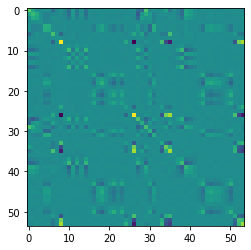

In [9]:
import matplotlib.pyplot as plt
plt.imshow(K_flat)